# GRAD-E1326: Python Programming for Data Scientists
## Ph.D. Hannah Béchara
### Ji Yoon Han & Mariana G. Carrillo 

** Final Project report: Tweet Sentiment Analysis**


In [1]:
#Importing libraries for sentiment analysis 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk #Natural Language Processing Package 
import os #functions for interacting with the operating system
import spacy #Models for NLP
import torch #also for NLP
from tqdm.notebook import tqdm 
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
import transformers #contains pretrained models to perform tasks on texts
from transformers import BertForSequenceClassification
from wordcloud import WordCloud #For nice wordclouds
import tensorflow as tf #Package to develop train models 
from tensorflow.keras.preprocessing import text 
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
import time #for handling dates and times
import re 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.metrics import AUC
from sklearn.metrics import confusion_matrix, classification_report
from nltk.tokenize import TweetTokenizer


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Loading data

In [4]:
#Loading and cleaning data
train_data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin-1')

In [5]:
#Train data 
#preview
train_data.head(5)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
#descriptive statistics
train_data.describe()

,UserName,ScreenName
count,41157.000000,41157.000000
mean,24377.000000,69329.000000
std,11881.146851,11881.146851
min,3799.000000,48751.000000
25%,14088.000000,59040.000000
50%,24377.000000,69329.000000
75%,34666.000000,79618.000000
max,44955.000000,89907.000000


In [7]:
#Test data
#preview
test_data.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


Data pre-processing

In [8]:
#descriptive statistics
test_data.describe()

,UserName,ScreenName
count,3798.000000,3798.000000
mean,1899.500000,46851.500000
std,1096.532489,1096.532489
min,1.000000,44953.000000
25%,950.250000,45902.250000
50%,1899.500000,46851.500000
75%,2848.750000,47800.750000
max,3798.000000,48750.000000


### Exploratory Data analysis

Text(0.5, 0.98, 'Histogram of tweet distribution per sentiment classification (Test data)')

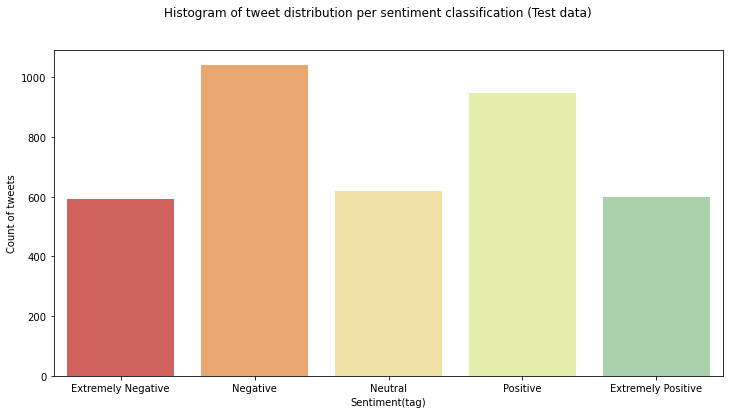

In [9]:
#Create histogram --> Distribution TEST DATA
#Can we also make this a function?
plt.figure(figsize=(12,6)) #specifying the size of the figure
sns.set_palette("Spectral") #color palette
sns.countplot(x='Sentiment', data=test_data, order=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], )
plt.xlabel('Sentiment(tag)')
plt.ylabel('Count of tweets')
plt.suptitle('Histogram of tweet distribution per sentiment classification (Test data)')


Text(0.5, 0.98, 'Histogram of tweet distribution per sentiment classification (Train data)')

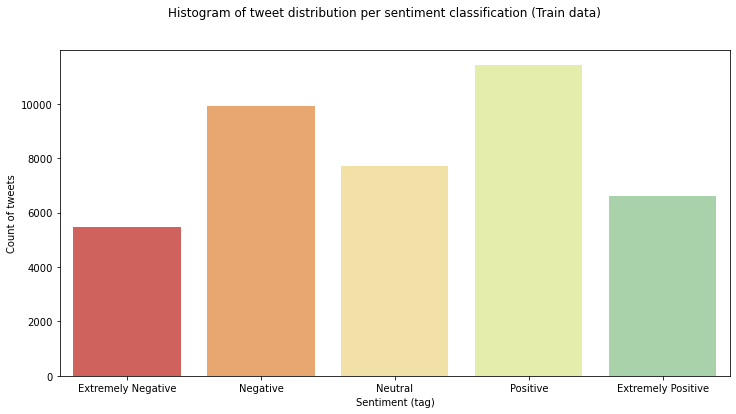

In [10]:
#Create histogram --> Distribution TRAIN DATA
plt.figure(figsize=(12,6))
sns.set_palette("Spectral")
sns.countplot(x='Sentiment', data=train_data, order=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], )
plt.xlabel('Sentiment (tag)')
plt.ylabel('Count of tweets')
plt.suptitle('Histogram of tweet distribution per sentiment classification (Train data)')

Text(0, 0.5, 'Tweet Count')

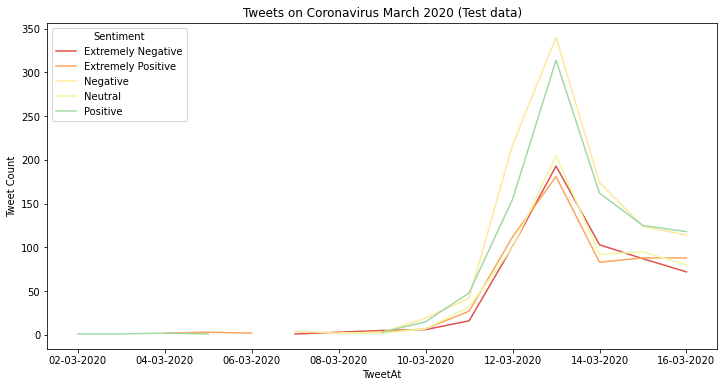

In [11]:
#Distribution of tweet counts --> TEST DATA
test_data.groupby(['TweetAt', 'Sentiment'])['OriginalTweet'].count().unstack().plot(kind='line', figsize=(12, 6))
plt.title('Tweets on Coronavirus March 2020 (Test data)')
plt.ylabel('Tweet Count')

Text(0, 0.5, 'Tweet Count')

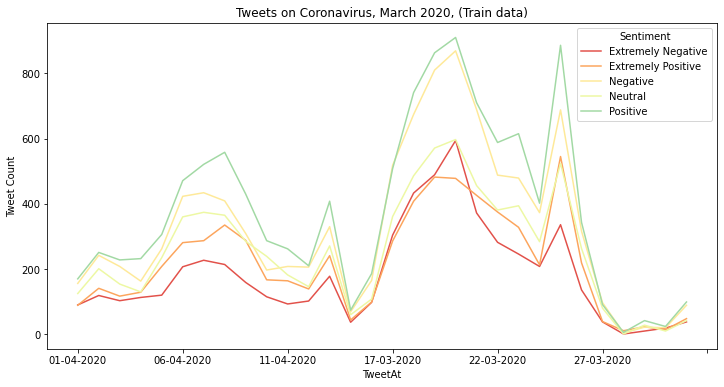

In [12]:
#Distribution of tweet counts --> TRAIN DATA 
train_data.groupby(['TweetAt', 'Sentiment'])['OriginalTweet'].count().unstack().plot(kind='line', figsize=(12, 6))
plt.title('Tweets on Coronavirus, March 2020, (Train data)')
plt.ylabel('Tweet Count')

### Data cleaning

In [13]:
# Import nltk / stopwords
import nltk
nltk.download('stopwords')

# Define stopwords 
stop_words = stopwords.words('english') #defining var to remove stopwords in the process_tweet function 

# Define function for cleaning tweets 
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', ' ', tweet) #removing urls
    tweet = re.sub(r'<.*?>', ' ', tweet)  # removing html tags    
    tweet = re.sub(r'\d+', ' ', tweet) #removing digits
    tweet = re.sub(r'#\w+', ' ', tweet)    #removing hashtags
    tweet = re.sub(r'@\w+', ' ', tweet) #removing mentions
    tweet = tweet.split() #removing stop words
    tweet = " ".join([word for word in tweet if not word in stop_words])
    return tweet

train_data['CleanTweet'] = train_data['OriginalTweet'].apply(lambda x: clean_tweet(x))
train_data.head(10)

# Clean tweets from test data by creating a new column in the test_data df
test_data['CleanTweet'] = test_data['OriginalTweet'].apply(lambda x: clean_tweet(x))
test_data.head(10)

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanTweet
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,TRENDING: New Yorkers encounter empty supermar...
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,"When I find hand sanitizer Fred Meyer, I turne..."
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,Find protect loved ones . ?
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits City anxious shoppers stock food&a...
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,# News # NewsMelb One week everyone buying bab...
5,6,44958,Los Angeles,03-03-2020,Do you remember the last time you paid $2.99 a...,Neutral,Do remember last time paid $ . gallon regular ...
6,7,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanit...,Positive,Voting age = hand sanitizer ?
7,8,44960,"Geneva, Switzerland",03-03-2020,"@DrTedros ""We canÂt stop #COVID19 without pro...",Neutral,"""We canÂt stop without protecting . Prices su..."
8,9,44961,NaN,04-03-2020,HI TWITTER! I am a pharmacist. I sell hand san...,Extremely Negative,HI TWITTER! I pharmacist. I sell hand sanitize...
9,10,44962,"Dublin, Ireland",04-03-2020,Anyone been in a supermarket over the last few...,Extremely Positive,Anyone supermarket last days? Went NORMAL shop...


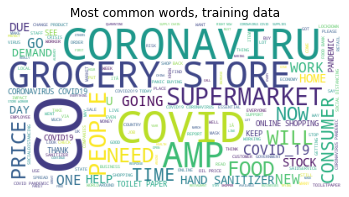

In [14]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#Attempt to create wordcloud - Train data
def wordcloud1(training_data):
    stopwords = set(STOPWORDS)
    stopwords.add("https")
    stopwords.add("00A0")
    stopwords.add("00BD")
    stopwords.add("00B8")
    stopwords.add("ed")
    wordcloud1 = WordCloud(background_color="white",stopwords=stopwords).generate(" ".join([i for i in train_data['OriginalTweet'].str.upper()]))
    plt.imshow(wordcloud1)
    plt.axis("off")
    plt.title("Most common words, training data")
    figsize=(12, 6)

wordcloud1(train_data)  

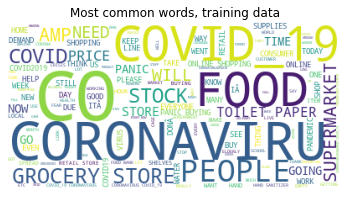

In [15]:
#Attempt to create wordcloud - test data
def wordcloud2(test_data):
    stopwords = set(STOPWORDS)
    stopwords.add("https")
    stopwords.add("00A0")
    stopwords.add("00BD")
    stopwords.add("00B8")
    stopwords.add("ed")
    wordcloud2 = WordCloud(background_color="white",stopwords=stopwords).generate(" ".join([i for i in test_data['OriginalTweet'].str.upper()]))
    plt.imshow(wordcloud2)
    plt.axis("off")
    plt.title("Most common words, training data")
    figsize=(12, 6)

wordcloud2(test_data)  

### Tokenization

In [16]:
## tweet tokenizer 

import nltk
nltk.download('punkt')

from nltk.tokenize import TweetTokenizer 

compare_list = train_data['CleanTweet'].head(10)

## need to add code to clean test_data

tweet_tokenizer = TweetTokenizer()

tweet_tokens = []
for sent in compare_list:
    print(tweet_tokenizer.tokenize(sent))
    tweet_tokens.append(tweet_tokenizer.tokenize(sent))


[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[]
['advice', 'Talk', 'neighbours', 'family', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'phone', 'numbers', 'neighbours', 'schools', 'employer', 'chemist', 'GP', 'set', 'online', 'shopping', 'accounts', 'poss', 'adequate', 'supplies', 'regular', 'meds', 'order']
['Coronavirus', 'Australia', ':', 'Woolworths', 'give', 'elderly', ',', 'disabled', 'dedicated', 'shopping', 'hours', 'amid', 'COVID', '-', 'outbreak']
['My', 'food', 'stock', 'one', 'empty', '...', 'PLEASE', ',', 'panic', ',', 'THERE', 'WILL', 'BE', 'ENOUGH', 'FOOD', 'FOR', 'EVERYONE', 'take', 'need', '.', 'Stay', 'calm', ',', 'stay', 'safe', '.', 'france']
['Me', ',', 'ready', 'go', 'supermarket', 'outbreak', '.', 'Not', "I'm", 'paranoid', ',', 'food', 'stock', 'litteraly', 'empty', '.', 'The', 'serious', 'thing', ',', 'please', ',', 'panic', '.', 'It', 'causes', 'shortage', '...']
['As', 'news',

In [17]:
display(train_data['CleanTweet'].head(5)) #Tokenizer worked?

0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: CleanTweet, dtype: object

## BoW and Ridge Regression


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, cross_val_score, KFold

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV


In [21]:
#Generate vectorizer 
#The vectorizer is creating a bag of words of the clean tweets

Vectorizer_mgc = CountVectorizer()
Vectorizer_mgc.fit(train_data)
X_train = Vectorizer_mgc.fit_transform(train_data['CleanTweet']) #X_train 
X_test = train_data['Sentiment'] #Y_train
Y_train = Vectorizer_mgc.transform(test_data['CleanTweet']) #X_test
Y_test = test_data['Sentiment'] # Y_test


### Classifier using Ridge Regression

This classifier first converts the target values into {-1, 1} and then treats the problem as a regression task (multi-output regression in the multiclass case).

In [22]:
#Using linear model -  MEAN accuracy of ~50% , LOL not very accurate
#Specifying alpha we 
import sklearn
from sklearn import linear_model

alpha = [80.0, 90.0, 100.0] 
for a in alpha:
    lm = linear_model.RidgeClassifier(a)
    scores = sklearn.model_selection.cross_val_score(lm, X_train, X_test, cv=5) #Return the mean accuracy on the given test data and labels
    print("alpha: ",a)
    print(scores)
    print(np.mean(scores))
    print('\n')
    

alpha:  80.0
[0.5409378  0.55114189 0.55060139 0.55072288 0.55315272]
0.549311333259895


alpha:  90.0
[0.53984451 0.55077745 0.54817155 0.54829304 0.55169481]
0.5477562720942031


alpha:  100.0
[0.53814383 0.54944121 0.5473211  0.54562022 0.54950796]
0.5460068622273353




## Vectorizing & Logit regression

### BOW

In [23]:
#This is also using count vectorizer, which is basically the same I am doing in the other chunk 
bow_converter = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
x = bow_converter.fit_transform(train_data['CleanTweet'])  #This is another process to generate a BoW

words = bow_converter.get_feature_names()
len(words)

127

In [24]:
#Bigram converter

bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase=False) 
x2 = bigram_converter.fit_transform(train_data['CleanTweet'])
bigrams = bigram_converter.get_feature_names()
len(bigrams)

4466

In [25]:
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False) 
x3 = trigram_converter.fit_transform(train_data['CleanTweet'])
trigrams = trigram_converter.get_feature_names()
len(trigrams)

36593

In [26]:
print(len(words), len(bigrams), len(trigrams))

127 4466 36593


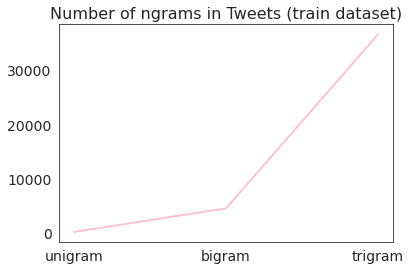

In [27]:
sns.set_style("white")
counts = [len(words), len(bigrams), len(trigrams)]
plt.plot(counts, color='pink')
plt.plot(counts, 'pink')
#plt.margins(0.1)
plt.ticklabel_format(style = 'plain')
plt.xticks(range(3), ['unigram', 'bigram', 'trigram'])
plt.tick_params(labelsize=14)
plt.title('Number of ngrams in Tweets (train dataset)', {'fontsize':16})
plt.show()

In [46]:
#Splitting train/test data
train_data, test_data = sklearn.model_selection.train_test_split(train_data, train_size = 0.7, random_state=42)

In [47]:
#check matrix shape

print(train_data.shape)
print(test_data.shape)

(28809, 7)
(12348, 7)


In [48]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False)

In [50]:
X_tr_bow = bow_transform.fit_transform(train_data['CleanTweet'])

In [51]:
len(bow_transform.vocabulary_)

32423

In [52]:

X_tr_bow.shape

(28809, 32423)

In [54]:
X_te_bow = bow_transform.transform(test_data['CleanTweet'])

In [55]:
y_tr = train_data['Sentiment']
y_te = test_data['Sentiment']

### Logit regression classifier


In [63]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
    
def Logit_Classifier(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    score = model.score(X_test, y_test)
    print('Test Score with', description, 'features', score)
    return model

In [64]:
#Accuracy of 51% (not much better than the Ridge Regression)
model_bow = Logit_Classifier(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')


Test Score with bow features 0.5196793002915452


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### References 
* Matplotlib.org. 2020. Pyplot Tutorial — Matplotlib 3.3.2 Documentation. [online] Available at: <https://matplotlib.org/tutorials/introductory/pyplot.html> [Accessed 20 October 2020].
* Kaggle.com. 2020. Sentiment Prediction. [online] Available at: <https://www.kaggle.com/shahraizanwar/covid19-tweets-sentiment-prediction-rnn-85-acc> [Accessed 18 October 2020].
* https://www.datacamp.com/community/tutorials/random-forests-classifier-python
* https://medium.com/better-programming/twitter-sentiment-analysis-using-naive-bayes-and-n-gram-5df42ae4bfc6